In [ ]:
# Import necessary modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.cluster import KMeans

from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, confusion_matrix, mean_squared_error, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score, f1_score, log_loss, recall_score, precision_score
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
np.random.seed(5)
import time
plt.style.use('seaborn')

# **Load the Preprocessed Data**


In [ ]:
df = pd.read_csv('processed_heart.csv')

In [ ]:
# Check the shape of dataset

print(df.shape)

(303, 23)


In [ ]:
# Information of data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   trestbps  302 non-null    float64
 3   chol      302 non-null    float64
 4   fbs       302 non-null    float64
 5   restecg   302 non-null    float64
 6   thalach   302 non-null    float64
 7   exang     302 non-null    float64
 8   oldpeak   302 non-null    float64
 9   slope     302 non-null    float64
 10  target    302 non-null    float64
 11  cp_0      302 non-null    float64
 12  cp_1      302 non-null    float64
 13  cp_2      302 non-null    float64
 14  cp_3      302 non-null    float64
 15  ca_0      302 non-null    float64
 16  ca_1      302 non-null    float64
 17  ca_2      302 non-null    float64
 18  ca_3      302 non-null    float64
 19  ca_4      302 non-null    float64
 20  thal_0    302 non-null    float6

In [ ]:
# print data

df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,target,cp_0,cp_1,cp_2,cp_3,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2
0,0.708333,1.0,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.166667,1.0,0.339623,0.283105,0.0,1.0,0.885496,0.0,0.564516,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.250000,2.0,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.562500,1.0,0.245283,0.251142,0.0,1.0,0.816794,0.0,0.129032,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.583333,2.0,0.245283,0.520548,0.0,1.0,0.702290,1.0,0.096774,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Separate the test dataset into target label and feature variables

X = df.drop('target', axis = 1)
y = df['target']

In [ ]:
X.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,cp_0,cp_1,cp_2,cp_3,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2
0,0.708333,1.0,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.166667,1.0,0.339623,0.283105,0.0,1.0,0.885496,0.0,0.564516,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.250000,2.0,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.562500,1.0,0.245283,0.251142,0.0,1.0,0.816794,0.0,0.129032,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.583333,2.0,0.245283,0.520548,0.0,1.0,0.702290,1.0,0.096774,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# **Machine Learning Models**

### Split the data into Train, Test and Unlabelled data

In [ ]:
df = pd.concat([X, y], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    float64
 1   sex       302 non-null    float64
 2   trestbps  302 non-null    float64
 3   chol      302 non-null    float64
 4   fbs       302 non-null    float64
 5   restecg   302 non-null    float64
 6   thalach   302 non-null    float64
 7   exang     302 non-null    float64
 8   oldpeak   302 non-null    float64
 9   slope     302 non-null    float64
 10  cp_0      302 non-null    float64
 11  cp_1      302 non-null    float64
 12  cp_2      302 non-null    float64
 13  cp_3      302 non-null    float64
 14  ca_0      302 non-null    float64
 15  ca_1      302 non-null    float64
 16  ca_2      302 non-null    float64
 17  ca_3      302 non-null    float64
 18  ca_4      302 non-null    float64
 19  thal_0    302 non-null    float64
 20  thal_1    302 non-null    float6

In [ ]:
# Assign data to train, test, and unlabeled sets

def reset_holdout_splits(X,y, unlabelled_size,holdout_test_size=0.2): 

  X_holdout, X_unlabelled, y_holdout, y_unlabelled = train_test_split(X, y, 
                                                                     test_size=unlabelled_size, random_state=1, stratify=y)

  X_train, X_test, y_train, y_test = train_test_split(X_holdout, y_holdout, test_size=holdout_test_size,
                                                      random_state=1, stratify=y_holdout)

  return X_train, y_train, X_test, y_test, X_unlabelled


### Self-Training Function

In [ ]:
def selfTraining(clf, X_train, y_train, X_unlabelled, X_test, y_test, confidence_score, auto_balancing=False): 
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = []
    train_f1s = []
    test_f1s = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
            
        # Fit classifier and make train/test predictions
        clf.fit(X_train, y_train)
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        test_acc = accuracy_score(y_test, y_hat_test)
        train_f1 = f1_score(y_train, y_hat_train)
        test_f1 = f1_score(y_test, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Test Accuracy: {test_acc}")
        print(f"Train f1: {train_f1}")
        print(f"Test f1: {test_f1}")
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
        test_accuracy.append(test_acc)
    
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = clf.predict_proba(X_unlabelled)
        preds = clf.predict(X_unlabelled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabelled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > confidence_score],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > confidence_score]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train = pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds])      
        
        if auto_balancing:
          merged_df = pd.concat([X_train, y_train], axis=1)
          zero_count = len(y_train[y_train == 0])
          one_count = len(y_train[y_train == 1])

          is_balanced_data = False
          if zero_count == one_count:
            is_balanced_data = True
          
          if not(is_balanced_data):
            sampler = SMOTE(sampling_strategy=1)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabelled = X_unlabelled.drop(index=high_prob.index)
        print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
        
        # Update iteration counter
        iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

### Co-Training Function

In [ ]:
def coTraining(clf1, clf2, view1, view2, X_train, y_train, X_unlabelled, X_test, y_test, confidence_score, auto_balancing=False):
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = {0: [], 1:[]}

    train_f1s = {0: [],1: []}

    test_f1s = {0: [],1: []}

    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # cotraining classifiers 
    clfs = [clf1, clf2]
    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
        
        # Fit classifier and make train/test predictions
        for i in [0,1]: 

            clf = clfs[i]

            if i == 0:
                X_train = X_train[view1]
                X_test = X_test[view1]
                X_unlabelled = X_unlabelled[view1]
            else: 
                X_train = X_train[view2]
                X_test = X_test[view2]
                X_unlabelled = X_unlabelled[view2]
            
            clf.fit(X_train, y_train)

            y_hat_train = clf.predict(X_train)
            y_hat_test = clf.predict(X_test)

            # Calculate and print iteration # and f1 scores, and store f1 scores
            test_acc = accuracy_score(y_test, y_hat_test)
            train_f1 = f1_score(y_train, y_hat_train)
            test_f1 = f1_score(y_test, y_hat_test)
            print(f"Iteration {iterations}, Classifier: {i}")
            print(f"Clf: {i}: Test Accuracy: {test_acc}")
            print(f"Clf: {i}: Train f1: {train_f1}")
            print(f"Clf: {i}: Test f1: {test_f1}")
            test_accuracy[i].append(test_acc)
            train_f1s[i].append(train_f1)
            test_f1s[i].append(test_f1)
            
            # Generate predictions and probabilities for unlabeled data
            print(f"Now predicting labels for unlabeled data...")

            pred_probs = clf.predict_proba(X_unlabelled)
            preds = clf.predict(X_unlabelled)
            prob_0 = pred_probs[:,0]
            prob_1 = pred_probs[:,1]

            # Store predictions and probabilities in dataframe
            df_pred_prob = pd.DataFrame([])
            df_pred_prob['preds'] = preds
            df_pred_prob['prob_0'] = prob_0
            df_pred_prob['prob_1'] = prob_1
            df_pred_prob.index = X_unlabelled.index
            
            # Separate predictions with > 99% probability
            high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > confidence_score],
                                    df_pred_prob.loc[df_pred_prob['prob_1'] > confidence_score]],
                                    axis=0)
            
            print(f"{len(high_prob)} high-probability predictions added to training data.")
            
            pseudo_labels.append(len(high_prob))

            # Add pseudo-labeled data to training data
            X_train = pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
            y_train = pd.concat([y_train, high_prob.preds])  

            if auto_balancing:
              merged_df = pd.concat([X_train, y_train], axis=1)
              zero_count = len(y_train[y_train == 0])
              one_count = len(y_train[y_train == 1])

              is_balanced_data = False
              if zero_count == one_count:
                is_balanced_data = True
                
              if not(is_balanced_data):
                sampler = SMOTE(sampling_strategy=1)
                X_train, y_train = sampler.fit_resample(X_train, y_train)
            
            # Drop pseudo-labeled instances from unlabeled data
            X_unlabelled = X_unlabelled.drop(index=high_prob.index)
            print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
            
            if (len(high_prob) == 0):
              break
            # Update iteration counter
            iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

### Boosting function (Assemble)

In [ ]:
def boosting_assemble(clf, X_train, y_train, X_unlabelled, X_test, y_test, margin, auto_balancing=False): 
    # Initiate iteration counter
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = []
    train_f1s = []
    test_f1s = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
            
        # Fit classifier and make train/test predictions
        clf = clf.fit(X_train,y_train)
        
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        test_acc = accuracy_score(y_test, y_hat_test)
        train_f1 = f1_score(y_train, y_hat_train)
        test_f1 = f1_score(y_test, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Test Accuracy: {test_acc}")
        print(f"Train f1: {train_f1}")
        print(f"Test f1: {test_f1}")
        test_accuracy.append(test_acc)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
    
        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = clf.predict_proba(X_unlabelled)
        preds = clf.predict(X_unlabelled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabelled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > margin],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > margin]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train =  pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds]) 
        
        if auto_balancing:
          merged_df = pd.concat([X_train, y_train], axis=1)
          zero_count = len(y_train[y_train == 0])
          one_count = len(y_train[y_train == 1])

          is_balanced_data = False
          if zero_count == one_count:
            is_balanced_data = True
        
          if not(is_balanced_data):
            sampler = SMOTE(sampling_strategy=1)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabelled = X_unlabelled.drop(index=high_prob.index)
        print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
        
        # Update iteration counter
        iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

### Unsupervised Clustering/Pre-processing function

In [ ]:
def unsupervised_labelling (clf, X_train, y_train, X_unlabelled, X_test, y_test, confidence_score, auto_balancing=False): 
    iterations = 0

    # Containers to hold f1_scores and # of pseudo-labels
    test_accuracy = []
    train_f1s = []
    test_f1s = []
    pseudo_labels = []

    # Assign value to initiate while loop
    high_prob = [1]

    X_combined = pd.concat([X_train, X_test])
    y_combined = pd.concat([y_train, y_test])
    y_combined.reset_index(drop=True, inplace=True)

    kmeans = KMeans(n_clusters=2)
    kmeans.fit(X_combined)

    X_new_feature = kmeans.labels_
    X_new_feature = pd.DataFrame(X_new_feature,columns=['cluster'])
    
    X_combined.reset_index(drop=True,inplace=True)
    X_new_feature.reset_index(drop=True,inplace=True)

    X_new = pd.concat([X_combined, X_new_feature],axis=1)
    
    Unlabelled_new_feature = kmeans.predict(X_unlabelled)
    Unlabelled_new_feature = pd.DataFrame(Unlabelled_new_feature, columns=['cluster'])
    X_unlabelled.reset_index(drop=True,inplace=True)
    Unlabelled_new_feature.reset_index(drop=True,inplace=True)

    X_unlabelled = pd.concat([X_unlabelled, Unlabelled_new_feature],axis=1)

    print(f"{X_new.shape} {y_combined.shape}")
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_combined, test_size=0.1, stratify=y_combined)
    
    # Loop will run until there are no more high-probability pseudo-labels
    while len(high_prob) > 0:
            
        # Fit classifier and make train/test predictions
        clf.fit(X_train, y_train)
        y_hat_train = clf.predict(X_train)
        y_hat_test = clf.predict(X_test)

        # Calculate and print iteration # and f1 scores, and store f1 scores
        test_acc = accuracy_score(y_test, y_hat_test)
        train_f1 = f1_score(y_train, y_hat_train)
        test_f1 = f1_score(y_test, y_hat_test)
        print(f"Iteration {iterations}")
        print(f"Test Accuracy: {test_acc}")
        print(f"Train f1: {train_f1}")
        print(f"Test f1: {test_f1}")
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)
        test_accuracy.append(test_acc)

        # Generate predictions and probabilities for unlabeled data
        print(f"Now predicting labels for unlabeled data...")

        pred_probs = clf.predict_proba(X_unlabelled)
        preds = clf.predict(X_unlabelled)
        prob_0 = pred_probs[:,0]
        prob_1 = pred_probs[:,1]

        # Store predictions and probabilities in dataframe
        df_pred_prob = pd.DataFrame([])
        df_pred_prob['preds'] = preds
        df_pred_prob['prob_0'] = prob_0
        df_pred_prob['prob_1'] = prob_1
        df_pred_prob.index = X_unlabelled.index
        
        # Separate predictions with > 99% probability
        high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > confidence_score],
                            df_pred_prob.loc[df_pred_prob['prob_1'] > confidence_score]],
                            axis=0)
        
        print(f"{len(high_prob)} high-probability predictions added to training data.")
        
        pseudo_labels.append(len(high_prob))

        # Add pseudo-labeled data to training data
        X_train = pd.concat([X_train, X_unlabelled.loc[high_prob.index]], axis=0)
        y_train = pd.concat([y_train, high_prob.preds])      
        
        if auto_balancing:
          print("doing balancing")
          merged_df = pd.concat([X_train, y_train], axis=1)
          zero_count = len(y_train[y_train == 0])
          one_count = len(y_train[y_train == 1])

          is_balanced_data = False
          if zero_count == one_count:
            is_balanced_data = True
          
          if not(is_balanced_data):
            print("applying smote")
            sampler = SMOTE(sampling_strategy=1)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

        # Drop pseudo-labeled instances from unlabeled data
        X_unlabelled = X_unlabelled.drop(index=high_prob.index)
        print(f"{len(X_unlabelled)} unlabeled instances remaining.\n")
        
        # Update iteration counter
        iterations += 1

    fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_test, y_hat_test)
    roc_auc_clf = auc(fpr_clf, tpr_clf)

    roc_auc_params = [fpr_clf, tpr_clf, roc_auc_clf]
    return test_accuracy, test_f1s, roc_auc_params

# 1. 100% labelled data - Fully Supervised learning - Imbalanced

### Random Forest - Imbalanced

In [ ]:
print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))
print(np.any(np.isnan(y)))
print(np.all(np.isfinite(y)))

True
False
True
False


In [ ]:
X.fillna(0,inplace=True)
y.fillna(0,inplace=True)

In [ ]:
print(np.any(np.isnan(X)))
print(np.all(np.isfinite(X)))
print(np.any(np.isnan(y)))
print(np.all(np.isfinite(y)))

False
True
False
True


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

AxesSubplot(0.125,0.125;0.775x0.755)


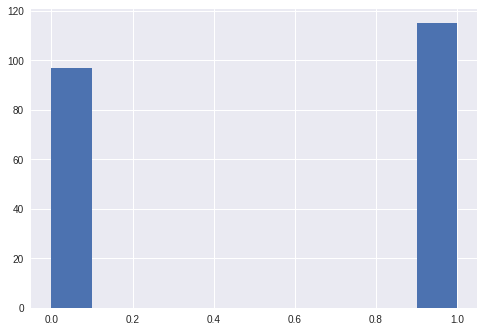

In [ ]:
print(y_train.hist())

In [ ]:
# Random Forest Classifier for Binary classification
%%time
param_grid = {'n_estimators':[22,33,111,251],
              'min_samples_split': [2,3,4,5,6],
              'min_samples_leaf': [1,2,3,4],
              'max_depth': [5, 7, 9],
              'n_jobs': [-1]}

# Random Forest Classifier
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, param_grid, scoring="f1", cv=5, return_train_score=False)
grid_rfc.fit(X_train, y_train)
pred_rfc = grid_rfc.predict(X_test)

# calculate and display our base accuracy
acc_score = accuracy_score(y_test, pred_rfc)
rfc_score = f1_score (y_test, pred_rfc)
print("Accuracy-Score: %s" % acc_score)
print("F1-Score: %s" % rfc_score)

# print classification report 
print(classification_report(y_test, pred_rfc))

Accuracy-Score: 0.8681318681318682
F1-Score: 0.8799999999999999
              precision    recall  f1-score   support

         0.0       0.88      0.83      0.85        42
         1.0       0.86      0.90      0.88        49

    accuracy                           0.87        91
   macro avg       0.87      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91

CPU times: user 3min 39s, sys: 10.1 s, total: 3min 49s
Wall time: 6min 49s


In [ ]:
print(grid_rfc.best_params_)

{'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 22, 'n_jobs': -1}


In [ ]:
%%time
# {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 22, 'n_jobs': -1}
rfc = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
rfc.fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

# calculate and display our base accuracy
rfc_f1_score = f1_score(y_test, pred_rfc)
rfc_acc_score = accuracy_score(y_test, pred_rfc)
print("F1-Score: %s" % rfc_f1_score)
print("Accuracy-Score: %s" % rfc_acc_score)

# print classification report 
print(classification_report(y_test, pred_rfc))

F1-Score: 0.9090909090909091
Accuracy-Score: 0.9010989010989011
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89        42
         1.0       0.90      0.92      0.91        49

    accuracy                           0.90        91
   macro avg       0.90      0.90      0.90        91
weighted avg       0.90      0.90      0.90        91

CPU times: user 75.4 ms, sys: 8.25 ms, total: 83.6 ms
Wall time: 232 ms


In [ ]:
fpr_imb, tpr_imb, thresholds_imb = roc_curve(y_test, pred_rfc)
roc_auc_imb = auc(fpr_imb, tpr_imb)

### Random Forest - Balanced

In [ ]:
smt = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = smt.fit_resample(X_train, y_train)
np.bincount(y_train_sampled)

array([115, 115])

In [ ]:
X_train_sampled = pd.DataFrame(X_train_sampled)
y_train_sampled = pd.DataFrame(y_train_sampled)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa81ed6d210>]],
      dtype=object)

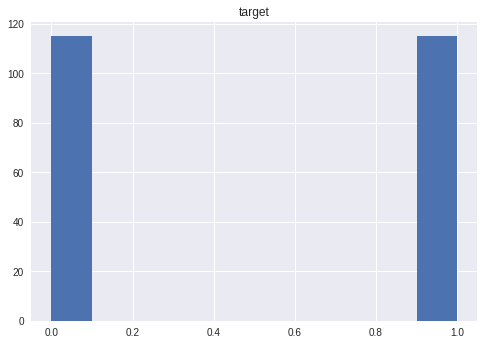

In [ ]:
y_train_sampled.hist()

In [ ]:
y_train_temp = y_train_sampled.values
y_train_sampled = np.ravel(y_train_temp)
y_train_sampled.shape

(230,)

In [ ]:
%%time
rfc = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
rfc.fit(X_train_sampled, y_train_sampled)
pred_rfc = rfc.predict(X_test)

# calculate and display our base accuracy
rfc_f1_score = f1_score(y_test, pred_rfc)
rfc_acc_score = accuracy_score(y_test, pred_rfc)
print("F1-Score: %s" % rfc_f1_score)
print("Accuracy Score: %s"%rfc_acc_score)

# print classification report 
print(classification_report(y_test, pred_rfc))

F1-Score: 0.9072164948453607
Accuracy Score: 0.9010989010989011
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89        42
         1.0       0.92      0.90      0.91        49

    accuracy                           0.90        91
   macro avg       0.90      0.90      0.90        91
weighted avg       0.90      0.90      0.90        91

CPU times: user 71 ms, sys: 7.46 ms, total: 78.4 ms
Wall time: 230 ms


In [ ]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test, pred_rfc)
roc_auc_bal = auc(fpr_bal, tpr_bal)

# 2. 10% unlabelled, 90% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_10_imb, st_f1_10_imb, st_10_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.8909090909090909
Train f1: 0.9572649572649573
Test f1: 0.90625
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
26 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8363636363636363
Train f1: 0.9586776859504132
Test f1: 0.8615384615384616
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
26 unlabeled instances remaining.

CPU times: user 233 ms, sys: 32.1 ms, total: 265 ms
Wall time: 1.11 s


### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_10_bal, st_f1_10_bal, st_10_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.9090909090909091
Train f1: 0.9658119658119658
Test f1: 0.9206349206349207
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
30 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8363636363636363
Train f1: 0.9495798319327732
Test f1: 0.8615384615384616
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
28 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8909090909090909
Train f1: 0.9620253164556962
Test f1: 0.9032258064516129
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
27 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8727272727272727
Train f1: 0.9583333333333334
Test f1: 0.888888888888889
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
27 unlabeled instances remaining.

CPU times: user 527 ms, sys: 244 ms, total: 771 ms
Wa

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_10_imb, ct_f1_10_imb, ct_10_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8545454545454545
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.870967741935484
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
23 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8545454545454545
Clf: 1: Train f1: 0.9551020408163264
Clf: 1: Test f1: 0.870967741935484
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
23 unlabeled instances remaining.

CPU times: user 177 ms, sys: 8.2 ms, total: 185 ms
Wall time: 601 ms


### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_10_bal, ct_f1_10_bal, ct_10_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8545454545454545
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.870967741935484
Now predicting labels for unlabeled data...
7 high-probability predictions added to training data.
24 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8181818181818182
Clf: 1: Train f1: 0.9512195121951219
Clf: 1: Test f1: 0.84375
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
23 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8545454545454545
Clf: 0: Train f1: 0.9959514170040485
Clf: 0: Test f1: 0.870967741935484
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
22 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.9090909090909091
Clf: 1: Train f1: 0.9512195121951219
Clf: 1: Test f1: 0.9206349206349207
Now predicting labels for unlabeled data...
1 high-probabi

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_10_imb, sse_f1_10_imb, sse_10_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.8545454545454545
Train f1: 0.9914529914529915
Test f1: 0.8749999999999999
Now predicting labels for unlabeled data...
17 high-probability predictions added to training data.
14 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8545454545454545
Train f1: 0.9920634920634921
Test f1: 0.8749999999999999
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
14 unlabeled instances remaining.

CPU times: user 125 ms, sys: 28.6 ms, total: 154 ms
Wall time: 258 ms


### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_10_bal, sse_f1_10_bal, sse_10_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.8545454545454545
Train f1: 0.9914529914529915
Test f1: 0.8749999999999999
Now predicting labels for unlabeled data...
17 high-probability predictions added to training data.
14 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8545454545454545
Train f1: 0.9920634920634921
Test f1: 0.8749999999999999
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
14 unlabeled instances remaining.

CPU times: user 147 ms, sys: 88.3 ms, total: 235 ms
Wall time: 155 ms


### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.1, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_10_imb, usl_f1_10_imb, usl_10_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(272, 23) (272,)
Iteration 0
Test Accuracy: 0.8214285714285714
Train f1: 0.9318181818181818
Test f1: 0.8275862068965518
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
28 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8214285714285714
Train f1: 0.929368029739777
Test f1: 0.8275862068965518
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
27 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8214285714285714
Train f1: 0.929368029739777
Test f1: 0.8275862068965518
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
26 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8571428571428571
Train f1: 0.9372693726937269
Test f1: 0.8666666666666667
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
22 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.85714285

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_10_bal, usl_f1_10_bal, usl_10_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(272, 23) (272,)
Iteration 0
Test Accuracy: 0.7142857142857143
Train f1: 0.9398496240601504
Test f1: 0.7142857142857142
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
doing balancing
applying smote
26 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.75
Train f1: 0.9481481481481482
Test f1: 0.7407407407407408
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
doing balancing
24 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.75
Train f1: 0.9416058394160584
Test f1: 0.7407407407407408
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
doing balancing
22 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.7142857142857143
Train f1: 0.9454545454545454
Test f1: 0.7142857142857142
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
doing balancing
applying smote
21 u

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
df = pd.concat([X,y],axis=1)
abs(df.corr()['target'])

age         0.208234
sex         0.289417
trestbps    0.137245
chol        0.072258
fbs         0.025264
restecg     0.137982
thalach     0.423304
exang       0.431894
oldpeak     0.424510
slope       0.348469
cp_0        0.509459
cp_1        0.248683
cp_2        0.315141
cp_3        0.088806
ca_0        0.473069
ca_1        0.228818
ca_2        0.271334
ca_3        0.208734
ca_4        0.048454
thal_0      0.006749
thal_1      0.104864
thal_2      0.527894
target      1.000000
Name: target, dtype: float64

In [ ]:
selected_features = ['age','sex','thalach','exang','oldpeak','slope','cp_0','cp_1','cp_2','ca_0','ca_1','thal_2']

X_intrinsic = X[selected_features]

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X_scaled_int = StandardScaler().fit_transform(X_intrinsic)
X_scaled_int = pd.DataFrame(X_scaled_int,columns=X_intrinsic.columns)

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.10, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (217, 12) (217,)
Unlabeled Train Set: (31, 12) (31,)
Test Set: (55, 12) (55,)
CPU times: user 7.29 ms, sys: 56 µs, total: 7.35 ms
Wall time: 8.04 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa820649cd0>]],
      dtype=object)

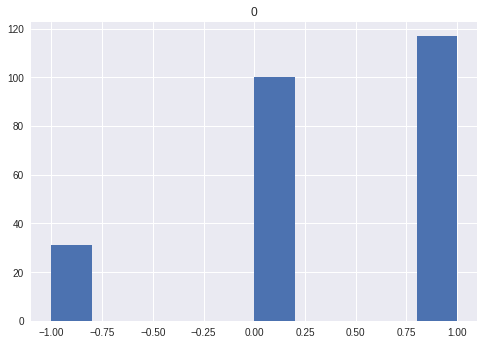

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
%%time
# define model

intrinsic_10_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_10_model_imb.classes_)
print(intrinsic_10_model_imb.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.7580645161290323
CPU times: user 15.4 ms, sys: 0 ns, total: 15.4 ms
Wall time: 21.3 ms


In [ ]:
y_pred = intrinsic_10_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8909090909090909
0.90625


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_10_imb, tpr_int_10_imb, thresholds_int_10_imb = roc_curve(y_test, y_pred)
auc_int_10_imb = auc(fpr_int_10_imb, tpr_int_10_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.10, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (234, 12) (234,)
Unlabeled Train Set: (31, 12) (31,)
Test Set: (55, 12) (55,)
CPU times: user 15.6 ms, sys: 6 µs, total: 15.6 ms
Wall time: 17 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa820077950>]],
      dtype=object)

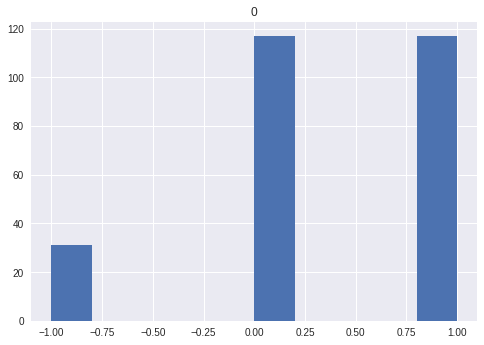

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_10_model_bal = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_10_model_bal.classes_)
print(intrinsic_10_model_bal.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.769811320754717
CPU times: user 15.6 ms, sys: 0 ns, total: 15.6 ms
Wall time: 15.9 ms


In [ ]:
y_pred = intrinsic_10_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8727272727272727
0.888888888888889


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_10_bal, tpr_int_10_bal, thresholds_int_10_bal = roc_curve(y_test, y_pred)
auc_int_10_bal = auc(fpr_int_10_bal, tpr_int_10_bal)

# 3. 20% unlabelled, 80% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_20_imb, st_f1_20_imb, st_20_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.9183673469387755
Train f1: 0.9519230769230769
Test f1: 0.9259259259259259
Now predicting labels for unlabeled data...
10 high-probability predictions added to training data.
51 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9183673469387755
Train f1: 0.9506726457399103
Test f1: 0.9285714285714286
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
50 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8775510204081632
Train f1: 0.9688888888888889
Test f1: 0.8888888888888888
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
47 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8775510204081632
Train f1: 0.9557522123893805
Test f1: 0.8928571428571429
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
46 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.9183673469387755
Train

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.1, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_20_bal, st_f1_20_bal, st_20_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.8545454545454545
Train f1: 0.9613733905579399
Test f1: 0.8787878787878789
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
28 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8727272727272727
Train f1: 0.9487179487179487
Test f1: 0.888888888888889
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
26 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8545454545454545
Train f1: 0.95
Test f1: 0.8749999999999999
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
26 unlabeled instances remaining.

CPU times: user 389 ms, sys: 233 ms, total: 622 ms
Wall time: 1.68 s


### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_20_imb, ct_f1_20_imb, ct_20_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8571428571428571
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.8679245283018868
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
41 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8367346938775511
Clf: 1: Train f1: 0.9583333333333334
Clf: 1: Test f1: 0.8571428571428572
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
40 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8571428571428571
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.8679245283018868
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
40 unlabeled instances remaining.

CPU times: user 211 ms, sys: 15.6 ms, total: 227 ms
Wall time: 643 ms


### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_20_bal, ct_f1_20_bal, ct_20_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8571428571428571
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.8679245283018868
Now predicting labels for unlabeled data...
9 high-probability predictions added to training data.
52 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.8775510204081632
Clf: 1: Train f1: 0.9511111111111111
Clf: 1: Test f1: 0.8928571428571429
Now predicting labels for unlabeled data...
7 high-probability predictions added to training data.
45 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8571428571428571
Clf: 0: Train f1: 0.9957805907172996
Clf: 0: Test f1: 0.8679245283018868
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
42 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.9387755102040817
Clf: 1: Train f1: 0.9535864978902953
Clf: 1: Test f1: 0.9433962264150944
Now predicting labels for unlabeled data...
1

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_20_imb, sse_f1_20_imb, sse_20_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.8979591836734694
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
33 high-probability predictions added to training data.
28 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8775510204081632
Train f1: 1.0
Test f1: 0.8928571428571429
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
25 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8979591836734694
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
25 unlabeled instances remaining.

CPU times: user 150 ms, sys: 5.01 ms, total: 155 ms
Wall time: 150 ms


### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.2, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_20_bal, sse_f1_20_bal, sse_20_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.8979591836734694
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
33 high-probability predictions added to training data.
28 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8571428571428571
Train f1: 1.0
Test f1: 0.8727272727272727
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
24 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8775510204081632
Train f1: 1.0
Test f1: 0.8888888888888888
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
23 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8367346938775511
Train f1: 1.0
Test f1: 0.8518518518518519
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
23 unlabeled instances remaining.

CPU times: user 339 ms, sys: 233 ms, total: 572 ms
Wall time: 322 ms


### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.2, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_20_imb, usl_f1_20_imb, usl_20_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(242, 23) (242,)
Iteration 0
Test Accuracy: 0.68
Train f1: 0.9663865546218487
Test f1: 0.6923076923076924
Now predicting labels for unlabeled data...
15 high-probability predictions added to training data.
46 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.64
Train f1: 0.9657794676806083
Test f1: 0.64
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
42 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.72
Train f1: 0.9575289575289576
Test f1: 0.7200000000000001
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
42 unlabeled instances remaining.

CPU times: user 395 ms, sys: 52.7 ms, total: 448 ms
Wall time: 1.67 s


### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.2, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_20_bal, usl_f1_20_bal, usl_20_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(242, 23) (242,)
Iteration 0
Test Accuracy: 0.88
Train f1: 0.9316239316239316
Test f1: 0.9032258064516129
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
doing balancing
applying smote
53 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.96
Train f1: 0.96
Test f1: 0.9655172413793104
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
doing balancing
applying smote
50 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.92
Train f1: 0.9523809523809523
Test f1: 0.9333333333333333
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
doing balancing
46 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.88
Train f1: 0.9649805447470817
Test f1: 0.9032258064516129
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
doing balancing
44 unlabeled instances remaining.

Iteration 4

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.20, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (193, 12) (193,)
Unlabeled Train Set: (61, 12) (61,)
Test Set: (49, 12) (49,)
CPU times: user 7.84 ms, sys: 0 ns, total: 7.84 ms
Wall time: 7.3 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa81ffa0410>]],
      dtype=object)

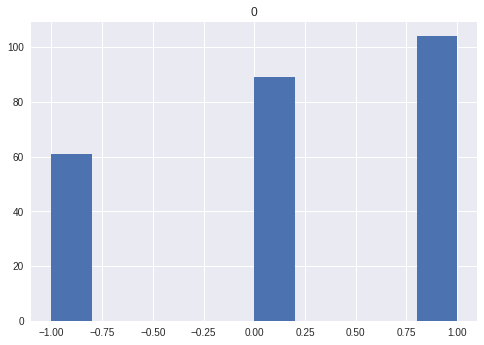

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_20_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_20_model_imb.classes_)
print(intrinsic_20_model_imb.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.6496062992125984
CPU times: user 16.3 ms, sys: 2.07 ms, total: 18.4 ms
Wall time: 18.7 ms


In [ ]:
y_pred = intrinsic_20_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8775510204081632
0.8800000000000001


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_20_imb, tpr_int_20_imb, thresholds_int_20_imb = roc_curve(y_test, y_pred)
auc_int_20_imb = auc(fpr_int_20_imb, tpr_int_20_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.20, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (208, 12) (208,)
Unlabeled Train Set: (61, 12) (61,)
Test Set: (49, 12) (49,)
CPU times: user 15.3 ms, sys: 953 µs, total: 16.3 ms
Wall time: 15.2 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8042ee790>]],
      dtype=object)

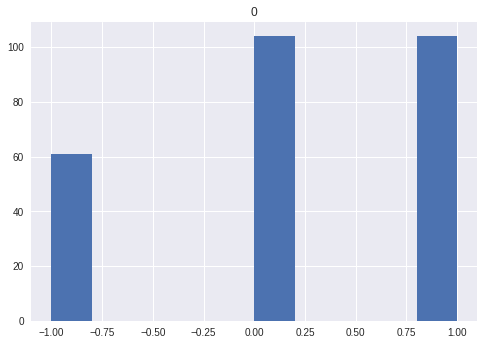

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_20_model_bal = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_20_model_bal.classes_)
print(intrinsic_20_model_bal.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.6728624535315985
CPU times: user 16.4 ms, sys: 1.91 ms, total: 18.3 ms
Wall time: 21.3 ms


In [ ]:
y_pred = intrinsic_20_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8775510204081632
0.8800000000000001


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_20_bal, tpr_int_20_bal, thresholds_int_20_bal = roc_curve(y_test, y_pred)
auc_int_20_bal = auc(fpr_int_20_bal, tpr_int_20_bal)

# 4. 50% unlabelled, 50% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_50_imb, st_f1_50_imb, st_50_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.7741935483870968
Train f1: 0.9465648854961831
Test f1: 0.7999999999999999
Now predicting labels for unlabeled data...
15 high-probability predictions added to training data.
137 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8387096774193549
Train f1: 0.9565217391304348
Test f1: 0.8484848484848485
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
132 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8387096774193549
Train f1: 0.963855421686747
Test f1: 0.8571428571428571
Now predicting labels for unlabeled data...
6 high-probability predictions added to training data.
126 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8064516129032258
Train f1: 0.9456521739130435
Test f1: 0.8333333333333333
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
124 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8387096774193549
Tr

### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_50_bal, st_f1_50_bal, st_50_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.8387096774193549
Train f1: 0.9545454545454547
Test f1: 0.8484848484848485
Now predicting labels for unlabeled data...
7 high-probability predictions added to training data.
145 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.8064516129032258
Train f1: 0.9517241379310345
Test f1: 0.8235294117647058
Now predicting labels for unlabeled data...
6 high-probability predictions added to training data.
139 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.8064516129032258
Train f1: 0.949367088607595
Test f1: 0.8125
Now predicting labels for unlabeled data...
14 high-probability predictions added to training data.
125 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8387096774193549
Train f1: 0.95906432748538
Test f1: 0.8571428571428571
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
122 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8387096774193549
Train f1: 0.9364

### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_50_imb, ct_f1_50_imb, ct_50_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8709677419354839
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.8888888888888888
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
152 unlabeled instances remaining.

CPU times: user 41.7 ms, sys: 0 ns, total: 41.7 ms
Wall time: 41.8 ms


### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_50_bal, ct_f1_50_bal, ct_50_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8709677419354839
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.8888888888888888
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
152 unlabeled instances remaining.

CPU times: user 47.4 ms, sys: 5 ms, total: 52.4 ms
Wall time: 47.4 ms


### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_50_imb, sse_f1_50_imb, sse_50_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.9032258064516129
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
76 high-probability predictions added to training data.
76 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9032258064516129
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
17 high-probability predictions added to training data.
59 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9032258064516129
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
6 high-probability predictions added to training data.
53 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.8709677419354839
Train f1: 1.0
Test f1: 0.8823529411764706
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
51 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8709677419354839
Train f1: 1.0
Test f1: 0.8823529411764706
Now predicting labels 

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.5, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_50_bal, sse_f1_50_bal, sse_50_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.9032258064516129
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
76 high-probability predictions added to training data.
76 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9032258064516129
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
18 high-probability predictions added to training data.
58 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.9032258064516129
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
5 high-probability predictions added to training data.
53 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.9032258064516129
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
51 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.9032258064516129
Train f1: 1.0
Test f1: 0.9090909090909091
Now predicting labels 

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.5, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_50_imb, usl_f1_50_imb, usl_50_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(151, 23) (151,)
Iteration 0
Test Accuracy: 0.8125
Train f1: 0.9315068493150684
Test f1: 0.8421052631578948
Now predicting labels for unlabeled data...
21 high-probability predictions added to training data.
131 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.875
Train f1: 0.9405405405405404
Test f1: 0.9
Now predicting labels for unlabeled data...
6 high-probability predictions added to training data.
125 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.75
Train f1: 0.924731182795699
Test f1: 0.7999999999999999
Now predicting labels for unlabeled data...
10 high-probability predictions added to training data.
115 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.875
Train f1: 0.941747572815534
Test f1: 0.9
Now predicting labels for unlabeled data...
7 high-probability predictions added to training data.
108 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.8125
Train f1: 0.9596412556053813
Test f1: 0.8421052631578948
Now predicting labels 

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.5, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_50_bal, usl_f1_50_bal, usl_50_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(151, 23) (151,)
Iteration 0
Test Accuracy: 0.9375
Train f1: 0.9370629370629371
Test f1: 0.9411764705882353
Now predicting labels for unlabeled data...
13 high-probability predictions added to training data.
doing balancing
applying smote
139 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.9375
Train f1: 0.9411764705882353
Test f1: 0.9473684210526316
Now predicting labels for unlabeled data...
13 high-probability predictions added to training data.
doing balancing
applying smote
126 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.875
Train f1: 0.9456521739130435
Test f1: 0.8750000000000001
Now predicting labels for unlabeled data...
9 high-probability predictions added to training data.
doing balancing
applying smote
117 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.875
Train f1: 0.9587628865979382
Test f1: 0.8750000000000001
Now predicting labels for unlabeled data...
6 high-probability predictions added to training data.
doing balancing
applyi

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.50, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (120, 12) (120,)
Unlabeled Train Set: (152, 12) (152,)
Test Set: (31, 12) (31,)
CPU times: user 5.7 ms, sys: 0 ns, total: 5.7 ms
Wall time: 5.55 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8031c25d0>]],
      dtype=object)

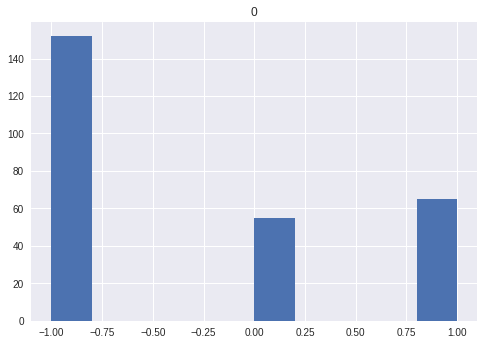

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_50_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_50_model_imb.classes_)
print(intrinsic_50_model_imb.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.375
CPU times: user 17.2 ms, sys: 1.07 ms, total: 18.3 ms
Wall time: 21.4 ms


In [ ]:
y_pred = intrinsic_50_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8709677419354839
0.8823529411764706


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_50_imb, tpr_int_50_imb, thresholds_int_50_imb = roc_curve(y_test, y_pred)
auc_int_50_imb = auc(fpr_int_50_imb, tpr_int_50_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.50, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (130, 12) (130,)
Unlabeled Train Set: (152, 12) (152,)
Test Set: (31, 12) (31,)
CPU times: user 13.2 ms, sys: 4 µs, total: 13.2 ms
Wall time: 12.6 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8041bc410>]],
      dtype=object)

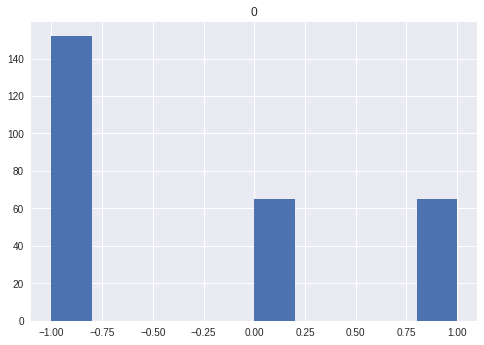

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_50_model_bal = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_50_model_bal.classes_)
print(intrinsic_50_model_bal.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.3971631205673759
CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 20.8 ms


In [ ]:
y_pred = intrinsic_50_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.8709677419354839
0.8749999999999999


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_50_bal, tpr_int_50_bal, thresholds_int_50_bal = roc_curve(y_test, y_pred)
auc_int_50_bal = auc(fpr_int_50_bal, tpr_int_50_bal)

# 5. 90% unlabelled, 10% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_90_imb, st_f1_90_imb, st_90_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
273 unlabeled instances remaining.

CPU times: user 114 ms, sys: 19.5 ms, total: 133 ms
Wall time: 548 ms


### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_90_bal, st_f1_90_bal, st_90_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
1 high-probability predictions added to training data.
272 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.5
Train f1: 1.0
Test f1: 0.5714285714285715
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
272 unlabeled instances remaining.

CPU times: user 240 ms, sys: 145 ms, total: 385 ms
Wall time: 1.12 s


### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_90_imb, ct_f1_90_imb, ct_90_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8333333333333334
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.8
Now predicting labels for unlabeled data...
41 high-probability predictions added to training data.
232 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.5
Clf: 1: Train f1: 1.0
Clf: 1: Test f1: 0.5714285714285715
Now predicting labels for unlabeled data...
9 high-probability predictions added to training data.
223 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.6666666666666666
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
215 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.6666666666666666
Clf: 1: Train f1: 1.0
Clf: 1: Test f1: 0.7499999999999999
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
213 unlabeled ins

### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_90_bal, ct_f1_90_bal, ct_90_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.8333333333333334
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.8
Now predicting labels for unlabeled data...
26 high-probability predictions added to training data.
247 unlabeled instances remaining.

Iteration 1, Classifier: 1
Clf: 1: Test Accuracy: 0.6666666666666666
Clf: 1: Train f1: 1.0
Clf: 1: Test f1: 0.7499999999999999
Now predicting labels for unlabeled data...
15 high-probability predictions added to training data.
232 unlabeled instances remaining.

Iteration 2, Classifier: 0
Clf: 0: Test Accuracy: 0.8333333333333334
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.8
Now predicting labels for unlabeled data...
20 high-probability predictions added to training data.
212 unlabeled instances remaining.

Iteration 3, Classifier: 1
Clf: 1: Test Accuracy: 0.6666666666666666
Clf: 1: Train f1: 1.0
Clf: 1: Test f1: 0.7499999999999999
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
209 unlabeled i

### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_90_imb, sse_f1_90_imb, sse_90_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
25 high-probability predictions added to training data.
248 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
17 high-probability predictions added to training data.
231 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
17 high-probability predictions added to training data.
214 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
10 high-probability predictions added to training data.
204 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting l

### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.9, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_90_bal, sse_f1_90_bal, sse_90_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
25 high-probability predictions added to training data.
248 unlabeled instances remaining.

Iteration 1
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
9 high-probability predictions added to training data.
239 unlabeled instances remaining.

Iteration 2
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
19 high-probability predictions added to training data.
220 unlabeled instances remaining.

Iteration 3
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
8 high-probability predictions added to training data.
212 unlabeled instances remaining.

Iteration 4
Test Accuracy: 0.6666666666666666
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting lab

### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.9, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_90_imb, usl_f1_90_imb, usl_90_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(30, 23) (30,)
Iteration 0
Test Accuracy: 1.0
Train f1: 0.962962962962963
Test f1: 1.0
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
271 unlabeled instances remaining.

Iteration 1
Test Accuracy: 1.0
Train f1: 0.9655172413793104
Test f1: 1.0
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
267 unlabeled instances remaining.

Iteration 2
Test Accuracy: 1.0
Train f1: 0.9743589743589743
Test f1: 1.0
Now predicting labels for unlabeled data...
2 high-probability predictions added to training data.
265 unlabeled instances remaining.

Iteration 3
Test Accuracy: 1.0
Train f1: 0.9743589743589743
Test f1: 1.0
Now predicting labels for unlabeled data...
4 high-probability predictions added to training data.
261 unlabeled instances remaining.

Iteration 4
Test Accuracy: 1.0
Train f1: 1.0
Test f1: 1.0
Now predicting labels for unlabeled data...
5 high-probability predictions added to training dat

### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.9, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_90_bal, usl_f1_90_bal, usl_90_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(30, 23) (30,)
Iteration 0
Test Accuracy: 1.0
Train f1: 1.0
Test f1: 1.0
Now predicting labels for unlabeled data...
6 high-probability predictions added to training data.
doing balancing
applying smote
267 unlabeled instances remaining.

Iteration 1
Test Accuracy: 1.0
Train f1: 0.9743589743589743
Test f1: 1.0
Now predicting labels for unlabeled data...
9 high-probability predictions added to training data.
doing balancing
applying smote
258 unlabeled instances remaining.

Iteration 2
Test Accuracy: 1.0
Train f1: 0.9795918367346939
Test f1: 1.0
Now predicting labels for unlabeled data...
18 high-probability predictions added to training data.
doing balancing
applying smote
240 unlabeled instances remaining.

Iteration 3
Test Accuracy: 1.0
Train f1: 0.9859154929577464
Test f1: 1.0
Now predicting labels for unlabeled data...
3 high-probability predictions added to training data.
doing balancing
applying smote
237 unlabeled instances remaining.

Iteration 4
Test Accuracy: 1.0
Train f1: 0.

### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.90, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (24, 12) (24,)
Unlabeled Train Set: (273, 12) (273,)
Test Set: (6, 12) (6,)
CPU times: user 5.11 ms, sys: 0 ns, total: 5.11 ms
Wall time: 4.63 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa804156750>]],
      dtype=object)

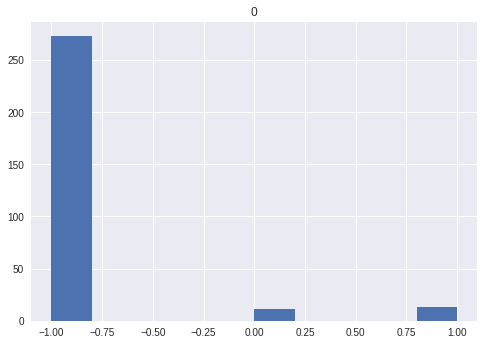

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_90_model_imb = LabelSpreading(alpha=0.1,max_iter=100, tol=0.01).fit(X_train_mixed, y_train_mixed)
print(intrinsic_90_model_imb.classes_)
print(intrinsic_90_model_imb.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.08080808080808081
CPU times: user 17 ms, sys: 10.4 ms, total: 27.4 ms
Wall time: 19.5 ms


In [ ]:
y_pred = intrinsic_90_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

1.0
1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_90_imb, tpr_int_90_imb, thresholds_int_90_imb = roc_curve(y_test, y_pred)
auc_int_90_imb = auc(fpr_int_90_imb, tpr_int_90_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.90, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy=1.0)
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (26, 12) (26,)
Unlabeled Train Set: (273, 12) (273,)
Test Set: (6, 12) (6,)
CPU times: user 13.5 ms, sys: 10.2 ms, total: 23.7 ms
Wall time: 19.4 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa81c57fd50>]],
      dtype=object)

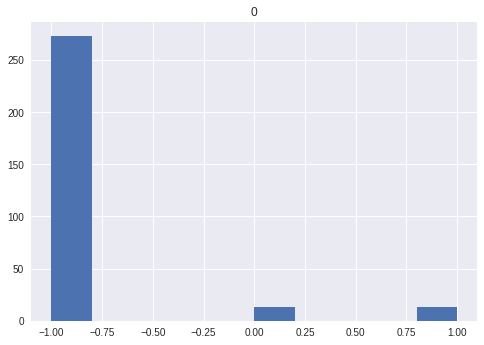

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_90_model_bal = LabelSpreading(alpha=0.1, max_iter=100, tol=0.01).fit(X_train_mixed, y_train_mixed)
print(intrinsic_90_model_bal.classes_)
print(intrinsic_90_model_bal.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.08695652173913043
CPU times: user 16.6 ms, sys: 17.6 ms, total: 34.2 ms
Wall time: 25.7 ms


In [ ]:
y_pred = intrinsic_90_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

1.0
1.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
fpr_int_90_bal, tpr_int_90_bal, thresholds_int_90_bal = roc_curve(y_test, y_pred)
auc_int_90_bal = auc(fpr_int_90_bal, tpr_int_90_bal)

# 6. 95% unlabelled, 5% labelled data 

### Self Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_95_imb, st_f1_95_imb, st_95_imb_roc = selfTraining(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score)

Iteration 0
Test Accuracy: 1.0
Train f1: 1.0
Test f1: 1.0
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
288 unlabeled instances remaining.

CPU times: user 114 ms, sys: 19.7 ms, total: 133 ms
Wall time: 555 ms


### Self Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
st_acc_95_bal, st_f1_95_bal, st_95_bal_roc = selfTraining(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score, auto_balancing=True)

Iteration 0
Test Accuracy: 1.0
Train f1: 1.0
Test f1: 1.0
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
288 unlabeled instances remaining.

CPU times: user 121 ms, sys: 17.5 ms, total: 139 ms
Wall time: 555 ms


### Co-Training - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_95_imb, ct_f1_95_imb, ct_95_imb_roc = coTraining(clf1, clf2, view1, view2, X_train,
                                                       y_train, X_unlabelled, X_test, y_test, confidence_score)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.3333333333333333
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.0
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
288 unlabeled instances remaining.

CPU times: user 28.2 ms, sys: 920 µs, total: 29.1 ms
Wall time: 31 ms


### Co-Training - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf1 = svm.SVC(probability=True, C=10, gamma=1, kernel='rbf')
clf2 = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)

view1 = X.columns
view2 = X.columns

confidence_score = 0.95

ct_acc_95_bal, ct_f1_95_bal, ct_95_bal_roc = coTraining(clf1, clf2, view1, view2, X_train, y_train, 
                                                       X_unlabelled, X_test, y_test, confidence_score,
                                                       auto_balancing=True)

Iteration 0, Classifier: 0
Clf: 0: Test Accuracy: 0.3333333333333333
Clf: 0: Train f1: 1.0
Clf: 0: Test f1: 0.0
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
288 unlabeled instances remaining.

CPU times: user 31.4 ms, sys: 1.97 ms, total: 33.3 ms
Wall time: 33.2 ms


### Semi-Supervised Ensemble - Imbalanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_95_imb, sse_f1_95_imb, sse_95_imb_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=False)


Iteration 0
Test Accuracy: 1.0
Train f1: 1.0
Test f1: 1.0
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
288 unlabeled instances remaining.

CPU times: user 31.7 ms, sys: 0 ns, total: 31.7 ms
Wall time: 32.4 ms


### Semi-Supervised Ensemble - Balanced

In [ ]:
%%time
import xgboost as xgb 
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,unlabelled_size=0.95, holdout_test_size=0.2)

clf = xgb.XGBClassifier(verbosity=0)

confidence_score = 0.95
sse_acc_95_bal, sse_f1_95_bal, sse_95_bal_roc = boosting_assemble(clf, X_train, y_train, X_unlabelled,
                                                             X_test, y_test, confidence_score,auto_balancing=True)


Iteration 0
Test Accuracy: 1.0
Train f1: 1.0
Test f1: 1.0
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
288 unlabeled instances remaining.

CPU times: user 36.8 ms, sys: 3.07 ms, total: 39.9 ms
Wall time: 43 ms


### Unsupervised labelling - Imbalanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X, y,
                                                                      unlabelled_size=0.95, holdout_test_size=0.2)


clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_95_imb, usl_f1_95_imb, usl_95_imb_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=False)

(15, 23) (15,)
Iteration 0
Test Accuracy: 0.5
Train f1: 1.0
Test f1: 0.6666666666666666
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
288 unlabeled instances remaining.

CPU times: user 157 ms, sys: 21.6 ms, total: 178 ms
Wall time: 574 ms


### Unsupervised labelling - Balanced

In [ ]:
%%time
X_train, y_train, X_test, y_test, X_unlabelled = reset_holdout_splits(X,y,
                                                                      unlabelled_size=0.95, holdout_test_size=0.2)

clf = RandomForestClassifier(n_estimators=22, max_depth=9, min_samples_leaf=3, min_samples_split=3, n_jobs=-1)
confidence_score = 0.95
usl_acc_95_bal, usl_f1_95_bal, usl_95_bal_roc = unsupervised_labelling(clf, X_train, y_train, 
                                                             X_unlabelled, X_test, y_test, confidence_score,auto_balancing=True)

(15, 23) (15,)
Iteration 0
Test Accuracy: 1.0
Train f1: 0.923076923076923
Test f1: 1.0
Now predicting labels for unlabeled data...
0 high-probability predictions added to training data.
doing balancing
applying smote
288 unlabeled instances remaining.

CPU times: user 170 ms, sys: 16 ms, total: 186 ms
Wall time: 582 ms


### Intrinsic - LabelSpreading - Imbalanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.95, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

# create the training dataset input
X_train_mixed = np.concatenate((X_train, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train.shape, y_train.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (12, 12) (12,)
Unlabeled Train Set: (288, 12) (288,)
Test Set: (3, 12) (3,)
CPU times: user 7.61 ms, sys: 2.04 ms, total: 9.65 ms
Wall time: 9.89 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa81c4ae090>]],
      dtype=object)

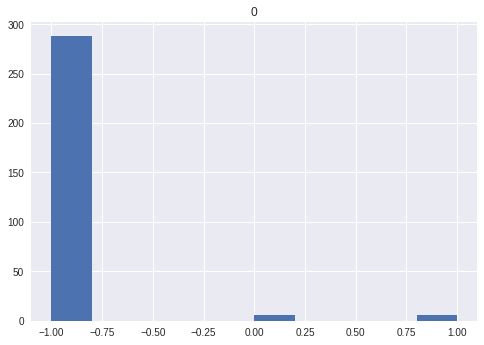

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_95_model_imb = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_95_model_imb.classes_)
print(intrinsic_95_model_imb.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.03666666666666667
CPU times: user 19.3 ms, sys: 1.08 ms, total: 20.3 ms
Wall time: 19.4 ms


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
y_pred = intrinsic_95_model_imb.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.6666666666666666
0.6666666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
confusion_matrix(y_test, y_pred)

array([[1, 0],
       [1, 1]])

In [ ]:
fpr_int_95_imb, tpr_int_95_imb, thresholds_int_95_imb = roc_curve(y_test, y_pred)
auc_int_95_imb = auc(fpr_int_95_imb, tpr_int_95_imb)

### Intrinsic - LabelSpreading - Balanced

In [ ]:
%%time
# split data into labeled and unlabeled
X_lab, X_unlab, y_lab, y_unlab = train_test_split(X_scaled_int , y, test_size=0.95, random_state=1, stratify=y)

# Split the labelled data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lab, y_lab, test_size=0.20, random_state=1, stratify=y_lab)

over_sampler = SMOTE(sampling_strategy='minority')
X_train_sampled, y_train_sampled = over_sampler.fit_resample(X_train, y_train)

# create the training dataset input
X_train_mixed = np.concatenate((X_train_sampled, X_unlab))

# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_unlab))]

# recombine training dataset labels
y_train_mixed = np.concatenate((y_train_sampled, nolabel))

# summarize training set size
print('Labeled Train Set:', X_train_sampled.shape, y_train_sampled.shape)
print('Unlabeled Train Set:', X_unlab.shape, y_unlab.shape)

# summarize test set size
print('Test Set:', X_test.shape, y_test.shape)

Labeled Train Set: (12, 12) (12,)
Unlabeled Train Set: (288, 12) (288,)
Test Set: (3, 12) (3,)
CPU times: user 9.58 ms, sys: 984 µs, total: 10.6 ms
Wall time: 10.6 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa81c44fd90>]],
      dtype=object)

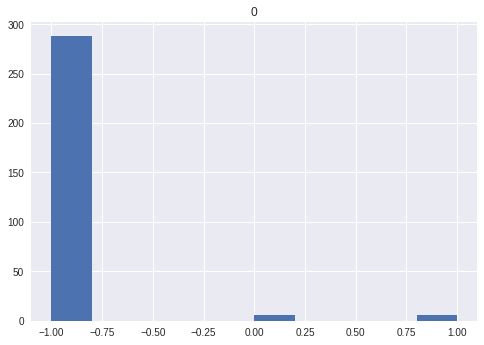

In [ ]:
pd.DataFrame(y_train_mixed).hist()

In [ ]:
# define model
%%time
intrinsic_95_model_bal = LabelSpreading(alpha=1e-4, max_iter=1000,n_neighbors=19, tol=0.24, kernel='knn').fit(X_train_mixed, y_train_mixed)
print(intrinsic_95_model_bal.classes_)
print(intrinsic_95_model_bal.score(X_train_mixed, y_train_mixed))

[0. 1.]
0.03666666666666667
CPU times: user 18.5 ms, sys: 897 µs, total: 19.4 ms
Wall time: 21.5 ms


/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
y_pred = intrinsic_95_model_bal.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}")
print(f"{f1_score(y_test, y_pred)}")

0.6666666666666666
0.6666666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but LabelSpreading was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/semi_supervised/_label_propagation.py:222: RuntimeWarning: invalid value encountered in true_divide
  probabilities /= normalizer


In [ ]:
confusion_matrix(y_test, y_pred)

array([[1, 0],
       [1, 1]])

In [ ]:
fpr_int_95_bal, tpr_int_95_bal, thresholds_int_95_bal = roc_curve(y_test, y_pred)
auc_int_95_bal = auc(fpr_int_95_bal, tpr_int_95_bal)

# ROC Curves

### 1. Fully Supervised

<Figure size 576x396 with 0 Axes>

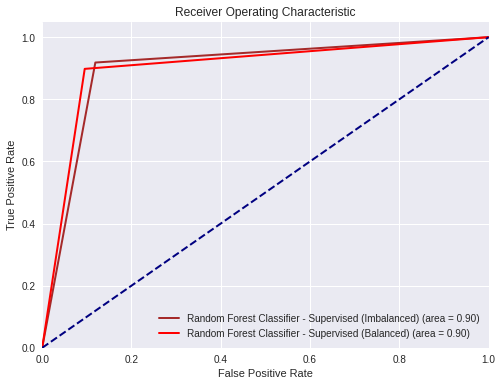

In [ ]:
plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_imb, tpr_imb, color='brown',
         lw=lw, label='Random Forest Classifier - Supervised (Imbalanced) (area = %0.2f)' % roc_auc_imb)
plt.plot(fpr_bal, tpr_bal, color='red',
         lw=lw, label='Random Forest Classifier - Supervised (Balanced) (area = %0.2f)' % roc_auc_bal)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 2. 10% Unlabeled Data

<Figure size 576x396 with 0 Axes>

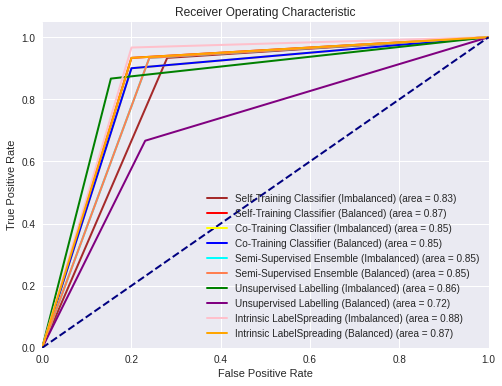

In [ ]:
fpr_st_10_imb, tpr_st_10_imb, auc_st_10_imb = st_10_imb_roc
fpr_st_10_bal, tpr_st_10_bal, auc_st_10_bal = st_10_bal_roc
fpr_ct_10_imb, tpr_ct_10_imb, auc_ct_10_imb = ct_10_imb_roc
fpr_ct_10_bal, tpr_ct_10_bal, auc_ct_10_bal = ct_10_bal_roc
fpr_sse_10_imb, tpr_sse_10_imb, auc_sse_10_imb = sse_10_imb_roc
fpr_sse_10_bal, tpr_sse_10_bal, auc_sse_10_bal = sse_10_bal_roc
fpr_usl_10_imb, tpr_usl_10_imb, auc_usl_10_imb = usl_10_imb_roc
fpr_usl_10_bal, tpr_usl_10_bal, auc_usl_10_bal = usl_10_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_10_imb, tpr_st_10_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_10_imb)
plt.plot(fpr_st_10_bal, tpr_st_10_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_10_bal)
plt.plot(fpr_ct_10_imb, tpr_ct_10_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_10_imb)
plt.plot(fpr_ct_10_bal, tpr_ct_10_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_10_bal)
plt.plot(fpr_sse_10_imb, tpr_sse_10_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_10_imb)
plt.plot(fpr_sse_10_bal, tpr_sse_10_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_10_bal)
plt.plot(fpr_usl_10_imb, tpr_usl_10_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_10_imb)
plt.plot(fpr_usl_10_bal, tpr_usl_10_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_10_bal)
plt.plot(fpr_int_10_imb, tpr_int_10_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_10_imb)
plt.plot(fpr_int_10_bal, tpr_int_10_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_10_bal)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 3. 20% Unlabeled Data

<Figure size 576x396 with 0 Axes>

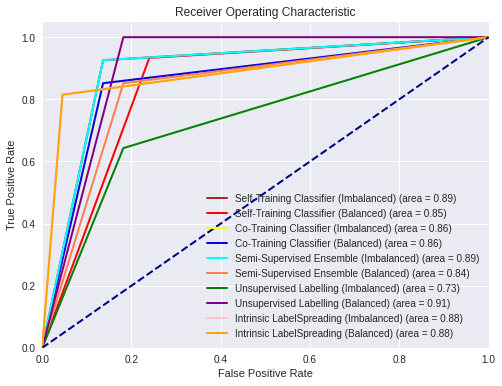

In [ ]:
fpr_st_20_imb, tpr_st_20_imb, auc_st_20_imb = st_20_imb_roc
fpr_st_20_bal, tpr_st_20_bal, auc_st_20_bal = st_20_bal_roc
fpr_ct_20_imb, tpr_ct_20_imb, auc_ct_20_imb = ct_20_imb_roc
fpr_ct_20_bal, tpr_ct_20_bal, auc_ct_20_bal = ct_20_bal_roc
fpr_sse_20_imb, tpr_sse_20_imb, auc_sse_20_imb = sse_20_imb_roc
fpr_sse_20_bal, tpr_sse_20_bal, auc_sse_20_bal = sse_20_bal_roc
fpr_usl_20_imb, tpr_usl_20_imb, auc_usl_20_imb = usl_20_imb_roc
fpr_usl_20_bal, tpr_usl_20_bal, auc_usl_20_bal = usl_20_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_20_imb, tpr_st_20_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_20_imb)
plt.plot(fpr_st_20_bal, tpr_st_20_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_20_bal)
plt.plot(fpr_ct_20_imb, tpr_ct_20_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_20_imb)
plt.plot(fpr_ct_20_bal, tpr_ct_20_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_20_bal)
plt.plot(fpr_sse_20_imb, tpr_sse_20_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_20_imb)
plt.plot(fpr_sse_20_bal, tpr_sse_20_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_20_bal)
plt.plot(fpr_usl_20_imb, tpr_usl_20_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_20_imb)
plt.plot(fpr_usl_20_bal, tpr_usl_20_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_20_bal)
plt.plot(fpr_int_20_imb, tpr_int_20_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_20_imb)
plt.plot(fpr_int_20_bal, tpr_int_20_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_20_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 4. 50% Unlabeled Data

<Figure size 576x396 with 0 Axes>

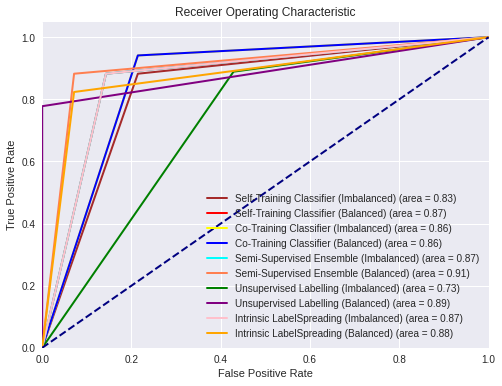

In [ ]:
fpr_st_50_imb, tpr_st_50_imb, auc_st_50_imb = st_50_imb_roc
fpr_st_50_bal, tpr_st_50_bal, auc_st_50_bal = st_50_bal_roc
fpr_ct_50_imb, tpr_ct_50_imb, auc_ct_50_imb = ct_50_imb_roc
fpr_ct_50_bal, tpr_ct_50_bal, auc_ct_50_bal = ct_50_bal_roc
fpr_sse_50_imb, tpr_sse_50_imb, auc_sse_50_imb = sse_50_imb_roc
fpr_sse_50_bal, tpr_sse_50_bal, auc_sse_50_bal = sse_50_bal_roc
fpr_usl_50_imb, tpr_usl_50_imb, auc_usl_50_imb = usl_50_imb_roc
fpr_usl_50_bal, tpr_usl_50_bal, auc_usl_50_bal = usl_50_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_50_imb, tpr_st_50_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_50_imb)
plt.plot(fpr_st_50_bal, tpr_st_50_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_50_bal)
plt.plot(fpr_ct_50_imb, tpr_ct_50_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_50_imb)
plt.plot(fpr_ct_50_bal, tpr_ct_50_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_50_bal)
plt.plot(fpr_sse_50_imb, tpr_sse_50_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_50_imb)
plt.plot(fpr_sse_50_bal, tpr_sse_50_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_50_bal)
plt.plot(fpr_usl_50_imb, tpr_usl_50_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_50_imb)
plt.plot(fpr_usl_50_bal, tpr_usl_50_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_50_bal)
plt.plot(fpr_int_50_imb, tpr_int_50_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_50_imb)
plt.plot(fpr_int_50_bal, tpr_int_50_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_50_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 5. 90% Unlabeled Data

<Figure size 576x396 with 0 Axes>

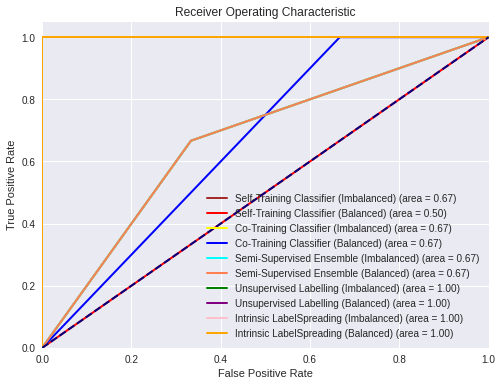

In [ ]:
fpr_st_90_imb, tpr_st_90_imb, auc_st_90_imb = st_90_imb_roc
fpr_st_90_bal, tpr_st_90_bal, auc_st_90_bal = st_90_bal_roc
fpr_ct_90_imb, tpr_ct_90_imb, auc_ct_90_imb = ct_90_imb_roc
fpr_ct_90_bal, tpr_ct_90_bal, auc_ct_90_bal = ct_90_bal_roc
fpr_sse_90_imb, tpr_sse_90_imb, auc_sse_90_imb = sse_90_imb_roc
fpr_sse_90_bal, tpr_sse_90_bal, auc_sse_90_bal = sse_90_bal_roc
fpr_usl_90_imb, tpr_usl_90_imb, auc_usl_90_imb = usl_90_imb_roc
fpr_usl_90_bal, tpr_usl_90_bal, auc_usl_90_bal = usl_90_bal_roc


plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_90_imb, tpr_st_90_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_90_imb)
plt.plot(fpr_st_90_bal, tpr_st_90_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_90_bal)
plt.plot(fpr_ct_90_imb, tpr_ct_90_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_90_imb)
plt.plot(fpr_ct_90_bal, tpr_ct_90_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_90_bal)
plt.plot(fpr_sse_90_imb, tpr_sse_90_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_90_imb)
plt.plot(fpr_sse_90_bal, tpr_sse_90_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_90_bal)
plt.plot(fpr_usl_90_imb, tpr_usl_90_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_90_imb)
plt.plot(fpr_usl_90_bal, tpr_usl_90_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_90_bal)
plt.plot(fpr_int_90_imb, tpr_int_90_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_90_imb)
plt.plot(fpr_int_90_bal, tpr_int_90_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_90_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### 6. 95% Unlabeled Data

<Figure size 576x396 with 0 Axes>

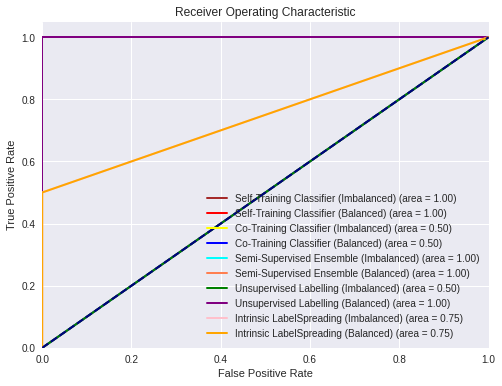

In [ ]:
fpr_st_95_imb, tpr_st_95_imb, auc_st_95_imb = st_95_imb_roc
fpr_st_95_bal, tpr_st_95_bal, auc_st_95_bal = st_95_bal_roc
fpr_ct_95_imb, tpr_ct_95_imb, auc_ct_95_imb = ct_95_imb_roc
fpr_ct_95_bal, tpr_ct_95_bal, auc_ct_95_bal = ct_95_bal_roc
fpr_sse_95_imb, tpr_sse_95_imb, auc_sse_95_imb = sse_95_imb_roc
fpr_sse_95_bal, tpr_sse_95_bal, auc_sse_95_bal = sse_95_bal_roc
fpr_usl_95_imb, tpr_usl_95_imb, auc_usl_95_imb = usl_95_imb_roc
fpr_usl_95_bal, tpr_usl_95_bal, auc_usl_95_bal = usl_95_bal_roc

plt.figure()
lw = 2
plt.figure(figsize=(8,6))

plt.plot(fpr_st_95_imb, tpr_st_95_imb, color='brown',
         lw=lw, label='Self-Training Classifier (Imbalanced) (area = %0.2f)' % auc_st_95_imb)
plt.plot(fpr_st_95_bal, tpr_st_95_bal, color='red',
         lw=lw, label='Self-Training Classifier (Balanced) (area = %0.2f)' % auc_st_95_bal)
plt.plot(fpr_ct_95_imb, tpr_ct_95_imb, color='yellow',
         lw=lw, label='Co-Training Classifier (Imbalanced) (area = %0.2f)' % auc_ct_95_imb)
plt.plot(fpr_ct_95_bal, tpr_ct_95_bal, color='blue',
         lw=lw, label='Co-Training Classifier (Balanced) (area = %0.2f)' % auc_ct_95_bal)
plt.plot(fpr_sse_95_imb, tpr_sse_95_imb, color='aqua',
         lw=lw, label='Semi-Supervised Ensemble (Imbalanced) (area = %0.2f)' % auc_sse_95_imb)
plt.plot(fpr_sse_95_bal, tpr_sse_95_bal, color='coral',
         lw=lw, label='Semi-Supervised Ensemble (Balanced) (area = %0.2f)' % auc_sse_95_bal)
plt.plot(fpr_usl_95_imb, tpr_usl_95_imb, color='green',
         lw=lw, label='Unsupervised Labelling (Imbalanced) (area = %0.2f)' % auc_usl_95_imb)
plt.plot(fpr_usl_95_bal, tpr_usl_95_bal, color='purple',
         lw=lw, label='Unsupervised Labelling (Balanced) (area = %0.2f)' % auc_usl_95_bal)
plt.plot(fpr_int_95_imb, tpr_int_95_imb, color='pink',
         lw=lw, label='Intrinsic LabelSpreading (Imbalanced) (area = %0.2f)' % auc_int_95_imb)
plt.plot(fpr_int_95_bal, tpr_int_95_bal, color='orange',
         lw=lw, label='Intrinsic LabelSpreading (Balanced) (area = %0.2f)' % auc_int_95_bal)


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()